# MATH50003 Numerical Analysis: Problem Sheet 4

This problem sheet explores least squares, the QR decomposition including for
tridiagonal matrices,
and the PLU decompositions.

Questions marked with a ⋆ are meant to be completed without using a computer.

In [1]:
using LinearAlgebra, Plots, Printf, Random, BenchmarkTools, Test
import Base: getindex, setindex!, size, *, \

## 1. Least squares and QR decompositions

**Problem 1.1** Find and plot the best least squares fit of ${1 \over 5x^2 + 1}$ by degree $n$
polynomials for $n = 0,\ldots,10$ at 1000 evenly spaced points between $0$ and $1$.

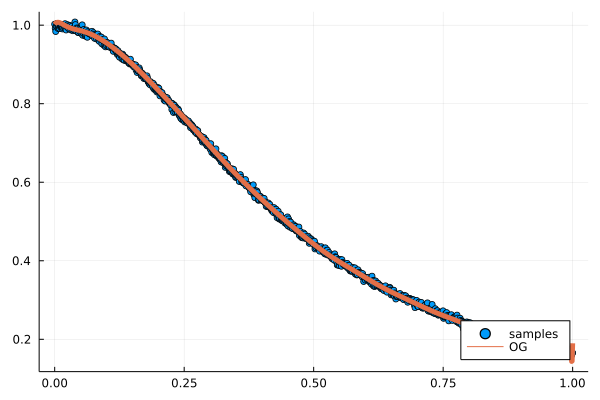

In [3]:
x = range(0, 1, length = 1000)
p = x -> 1 ./ (5 .* x .^ 2 .+ 1) + 0.005 .* randn.()
b = p.(x)

function q11(n)
    exp_vec = (0:(n-1))
    A = x .^ transpose(exp_vec);
    # Built-in QR
    Q, R = qr(A)
    # Take first n columns
    Q̂ = Q[:,1:n]
    # Built-in solve
    result = R \ (transpose(Q̂)b)
    plt = scatter(x, p.(x); label="samples", legend=:bottomright)
    plot!(x, A*result, linewidth = 5,  label = "OG")
    plt
end

plots = Array{Any}(nothing, 11)

q11(100)

**Problem 1.2⋆** Show that every matrix has a QR decomposition such that the diagonal of $R$ is non-negative.
Make sure to inlude the case of more columns than rows.

**Problem 1.3⋆** Show that the QR decomposition of a square invertible matrix is unique, 
provided that the diagonal of $R$ is positive.

In [6]:
B = randn(5,10)
Q, R = qr(B)
show(stdout, "text/plain", R)

5×10 Matrix{Float64}:
 2.47702  -0.0313722  1.83982   0.681701   0.629598   -0.024586    0.285248  -0.309283  -0.486426  -0.101087
 0.0      -1.41886    1.6193    1.41083   -0.390329    1.28749     0.727476   0.34316    0.904441  -0.236011
 0.0       0.0        1.69203   0.573527  -0.437733   -0.489546    1.12871    1.08055   -0.676999  -0.955519
 0.0       0.0        0.0      -2.09444   -0.341616   -0.0604211  -0.824226   1.15779    0.043062   0.118579
 0.0       0.0        0.0       0.0        0.0261752   0.758158   -0.618989   0.445772  -0.398404  -1.13651

## 2. Gram–Schmidt

**Problem 2.1⋆** The modified Gram–Schmidt algorithm is a slight variation of Gram–Schmidt where
instead of computing
$$
𝐯_j := 𝐚_j - \sum_{k=1}^{j-1} \underbrace{𝐪_k^\top 𝐚_j}_{r_{kj}} 𝐪_k
$$
we compute it step-by-step:
$$
\begin{align*}
𝐯_j^1 &:= 𝐚_j \\
𝐯_j^{k+1} &:= 𝐯_j^k - 𝐪_k^\top 𝐯_j^k 𝐪_k
\end{align*}
$$
Show that $𝐯_j^j = 𝐯_j$. 

**Problem 2.2** Complete the following
function implementing the modified Gram–Schmidt algorithm:

In [7]:
function modifiedgramschmidt(A)
    m,n = size(A)
    m ≥ n || error("Not supported")
    R = zeros(n,n)
    Q = zeros(m,n)
    for j = 1:n
        # TODO: Implement the Modified Gram–Schmidt algorthm
        vj = A[:,j]
        for k = 1:(j-1)
            R[k,j] = dot(Q[:,k], vj)
            vj = vj - dot(Q[:,k], vj) * Q[:,k]
        end
        R[j,j] = norm(vj)
        Q[:,j] = vj/R[j,j]
    end
    Q,R
end

Random.seed!(11451)
A = randn(5,4);

Q, R = modifiedgramschmidt(A);
Q₁, R₁ = qr(A);

norm(Q*R-A)
norm(Q₁*R₁-A)

@test Q*R ≈ A

Test Passed
  Expression: Q * R ≈ A
   Evaluated: [1.273784726933585 -0.5337467863972929 0.845314974128225 1.3232189576780222; -0.10791243870900036 -1.67060047157282 -0.007694025381635107 0.8682188203636925; … ; 1.6402754919431133 1.2768197950007996 0.4466826896005342 -0.7956410926839215; -0.27357595464910034 -1.1395815069151907 1.6341621822438879 1.816412557533649] ≈ [1.273784726933585 -0.5337467863972928 0.845314974128225 1.3232189576780222; -0.10791243870900036 -1.67060047157282 -0.007694025381635021 0.8682188203636925; … ; 1.6402754919431133 1.2768197950007996 0.4466826896005342 -0.7956410926839214; -0.27357595464910034 -1.1395815069151907 1.6341621822438877 1.8164125575336492]

**Problem 2.3** Compare the orthogonality of `Q` between `gramschmidt` and `modifiedgramschmidt`
when applied to a `300 × 300` random matrix.


In [12]:
A = randn(300,300)

Q, R = modifiedgramschmidt(A);
Q₁, R₁ = qr(A);

d1 = norm(Q*Q'-I)
d2 = norm(Q₁*Q₁'-I)

display([d1,d2])

2-element Vector{Float64}:
 1.9791154359003705e-13
 1.6828229387780487e-14


## 3. Householder reflections


**Problem 3.1**
Complete the definition of `Reflections` which supports a sequence of Householder reflections,
that is, 
$$
Q = Q_{𝐯_1} \cdots Q_{𝐯_n}
$$
where the vectors are stored as a matrix `V` whose $j$-th column is $𝐯_j$.

In [20]:
struct Reflections{T} <: AbstractMatrix{T}
    V::Matrix{T}
end

import Base: *, size, getindex

size(Q::Reflections) = (size(Q.V,1), size(Q.V,1))


function *(Q::Reflections, x::AbstractVector)
    # TODO: Apply Q in O(mn) operations
    n = size(Q.V, 2)
    for j in n:-1:1
        w = Q.V[:,j]
        x = x - 2*w*w'*x
    end
    x
end

function getindex(Q::Reflections, k::Int, j::Int)
    # TODO: Return Q[k,j] in O(mn) operations (hint: use *)
    m = size(Q.V,1)
    idx = zeros(m)
    idx[j] = 1
    vec = Q*idx
    vec[k]
end
v = [1,1,1]
v = v / norm(v)
v = reshape(v, length(v), 1)
Q = Reflections(v)

3×3 Reflections{Float64}:
  0.333333  -0.666667  -0.666667
 -0.666667   0.333333  -0.666667
 -0.666667  -0.666667   0.333333

Testing Implmentation

In [22]:
function householderreflection(x)
    y = copy(x)
    # we cannot use sign(x[1]) in case x[1] == 0
    y[1] += (x[1] ≥ 0 ? 1 : -1)*norm(x) 
    w = y/norm(y)
    I - 2*w*w'
end

function reflection(x)
    y = copy(x)
    w = y/norm(y)
    I - 2*w*w'
end

reflection(v)

3×3 Matrix{Float64}:
  0.333333  -0.666667  -0.666667
 -0.666667   0.333333  -0.666667
 -0.666667  -0.666667   0.333333

**Problem 3.2** Complete the following function that implements
 Householder QR using only $O(mn^2)$ operations:

In [23]:
function householderqr(A)
    m,n = size(A)
    R = copy(A)
    Q = Reflections(Matrix(1.0I, m, n))
    for j = 1:n
        # TODO: populate Q and R using O(m*j) operations

        # Create Householder reflection vec
        v = copy(R[j:end, j])
        ej = zeros(m)
        ej[j] = (v[1] ≥ 0 ? 1 : -1)*norm(v)
        ej[j:end] = ej[j:end]+v
        vj = ej / norm(ej)
        # Store it in Q
        Q.V[:,n-j+1] = vj
        # Apply without accessing
        R = Reflections(reshape(vj, length(vj), 1)) * R
    end
    Q,R
end
m,n = 7,5
Random.seed!(11451)
A = randn(m, n)
Q, R = householderqr(A)
@test Q'R ≈ A

Test Passed
  Expression: Q' * R ≈ A
   Evaluated: [1.2737847269335851 0.9755059696371078 … -0.20403272729650937 1.9550820133706108; -0.10791243870900033 1.2768197950008002 … -0.4696795688446498 -0.9248983972198223; … ; -0.5337467863972928 1.639458654813726 … -0.8737633878853155 1.351838260997529; -1.6706004715728198 0.44668268960053403 … 0.047955697050812755 -0.7956410926839209] ≈ [1.273784726933585 0.9755059696371075 … -0.20403272729650967 1.9550820133706115; -0.10791243870900036 1.2768197950007996 … -0.46967956884464956 -0.9248983972198235; … ; -0.5337467863972928 1.6394586548137255 … -0.8737633878853158 1.3518382609975295; -1.67060047157282 0.4466826896005342 … 0.047955697050813165 -0.7956410926839214]

Note $Q^T$ due to the fact that for reflection matrices $(Q_n \cdots Q_1)^T = (Q_1 \cdots Q_n)$

## 4. Banded QR with Given's rotations

**Problem 4.1⋆**  Describe an algorithm for computing the QR decomposition
of a tridiagonal matrix using rotations instead of reflections to upper-triangularise
column-by-column.

**Problem 4.2** Implement `Rotations` which represents an orthogonal matrix `Q` that is a product
 of rotations of angle `θ[k]`, each acting on the entries `k:k+1`.

In [2]:
struct Rotations{T} <: AbstractMatrix{T}
    θ::Vector{T}
end

import Base: *, size, getindex

size(Q::Rotations) = (length(Q.θ)+1, length(Q.θ)+1)


function *(Q::Rotations, x::AbstractVector)
    # TODO: Apply Q in O(n) operations
    n = size(Q, 1)
    for i in 1:(n-1)
        α = Q.θ[i]
        a = x[i]
        b = x[i+1]
        x[i] = cos(α)*a - sin(α)*b
        x[i+1] = sin(α)*a + cos(α)*b 
    end
    x
end

function getindex(Q::Rotations, k::Int, j::Int)
    # TODO: Return Q[k,j] in O(n) operations (hint: use *)
    n = size(Q,1)
    idx = zeros(n)
    idx[j] = 1
    vec = Q*idx
    vec[k]
end

Q₀ = Rotations([1,2,3])

4×4 Rotations{Int64}:
  0.540302  -0.841471    0.0         0.0
 -0.350175  -0.224845   -0.909297   -0.0
 -0.75749   -0.486379    0.411982   -0.14112
  0.107978   0.0693316  -0.0587266  -0.989992

**Problem 4.3** Combine `Rotations` and `UpperTridiagonal` from last problem sheet
to implement a banded QR decomposition that only takes $O(n)$ operations:

In [3]:
struct UpperTridiagonal{T} <: AbstractMatrix{T}
    d::Vector{T}   # diagonal entries
    du::Vector{T}  # super-diagonal enries
    du2::Vector{T} # second-super-diagonal entries
end

size(U::UpperTridiagonal) = (length(U.d),length(U.d))

function getindex(U::UpperTridiagonal, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    # TODO: return U[k,j]
    result = 0
    n = length(U.d)
    
    if j-k ==2
        result = du2[k]
    elseif j-k==1
        result = du[k]
    elseif k==j
        result = d[k]
    else
        result = 0
    end
    result
end

function setindex!(U::UpperTridiagonal, v, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    if j > k+2
        error("Cannot modify off-band")
    end

    # TODO: modify d,du,du2 so that U[k,j] == v
    if abs(k-j)==2
        du2[k] = v
    elseif abs(k-j)==1
        du[k] = v
    elseif k==j
        d[k] = v
    end
    U     # by convention we return the matrix
end

setindex! (generic function with 138 methods)

In [27]:
function bandedqr(A::Tridiagonal)
    n = size(A,1)
    Q = Rotations(zeros(n-1)) # Assume Float64
    R = UpperTridiagonal(zeros(n), zeros(n-1), zeros(n-2))
    T = Matrix(A)
    for j = 1:n-1
        # TODO: populate Q and R
        a = T[j, j]
        b = A[j+1, j]
        
        α = atan(-b, a)
        Q.θ[j] = α
        println(Rotations([α])*T[j:j+1,j])
        T[j:j+1,:] = Rotations([α])*T[j:j+1,:]
    end
    Q,T
end
A = Tridiagonal([1.0,2.0], [30.0,100.0,5.0], [6.0,7.0])

Q, T = bandedqr(A)
display(Q)
display(T)

3×3 Rotations{Float64}:
  0.999445      0.0333148  0.0
 -0.0333081     0.999244   0.0200472
  0.000667868  -0.0200361  0.999799

3×3 Matrix{Float64}:
 30.0167        9.32815      0.233204
  1.11e-16     99.7647       7.09494
 -2.22568e-18  -2.22045e-16  4.85874

[30.01666203960727, 1.1102230246251565e-16]
[99.76465091196944, -2.220446049250313e-16]


In [28]:
# Tests
using Test
function subTest4(k, func)
    Random.seed!(11451)
    vec1 = randn(k)
    vec2 = randn(k+1)
    vec3 = randn(k)
    B = Tridiagonal(vec1, vec2, vec3)
    Q, R = func(B)
    Q'R ≈ B 
end

@testset "Q4 Test 1 $i" for i in 3:10
    @test subTest4(i, bandedqr) == true
end

[1.2579091073667652, -7.37257477290143e-17]
[2.363022442379651, -2.220446049250313e-16]
[1.8523073668285193, 1.3877787807814457e-16]
Test Summary: | Pass  Total
Q4 Test 1 3   |    1      1
[1.7752619392759708, -1.1102230246251565e-16]
[1.8396346730278448, 2.3678975447083417e-16]
[1.8550000226301626, 3.0531133177191805e-16]
[0.1523610563779602, -9.974659986866641e-18]
Test Summary: | Pass  Total
Q4 Test 1 4   |    1      1
[1.282371430733159, 2.7755575615628914e-17]
[1.8405383669285251, 7.632783294297951e-17]
[1.8460904920681158, 2.2898349882893854e-16]
[0.04471892608013763, 4.336808689942018e-19]
[1.279089170060332, 1.1102230246251565e-16]
Test Summary: | Pass  Total
Q4 Test 1 5   |    1      1
[3.2314711280195683, 2.220446049250313e-16]
[2.5390955007814973, 2.220446049250313e-16]
[1.8716446925720933, 2.7755575615628914e-16]
[0.6973261055926558, 0.0]
[1.2766503838731322, -1.1102230246251565e-16]
[0.619864825197142, 0.0]
Test Summary: | Pass  Total
Q4 Test 1 6   |    1      1
[1.3851991

8-element Vector{Any}:
 Test.DefaultTestSet("Q4 Test 1 3", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 1 4", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 1 5", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 1 6", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 1 7", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 1 8", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 1 9", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 1 10", Any[], 1, false, false)

In [40]:
# Faster with UpperTri
function bandedqrUp(A::Tridiagonal)
    n = size(A,1)
    Q = Rotations(zeros(n-1)) # Assume Float64
    R = UpperTridiagonal{Float64}(zeros(n), zeros(n-1), zeros(n-2))
    R.d[1:end] = copy(A.d[1:end])
    R.du[1:end] = copy(A.du[1:end])
    
    for j = 1:n-1
        # TODO: populate Q and R
        a = R[j,j]
        b = A[j+1, j]
        α = atan(-b, a)

        Q.θ[j] = α
        rmat = Rotations([α])

        R[j,j] = (rmat*[R[j,j], b])[1]
        
        R[j:j+1,j+1] = rmat*R[j:j+1,j+1]

        if j != n-1
            # Populate the upper bands of R
            R[j:j+1, j+2] = rmat*R[j:j+1, j+2]
        end
    end
    Q,R
end
A = Tridiagonal([1.0,2.0], [30.0,100.0,5.0], [6.0,7.0]);

Q₂, R₂ = bandedqrUp(A);

@test Q₂'R₂ ≈ A

Test Passed
  Expression: Q₂' * R₂ ≈ A
   Evaluated: [30.0 6.0 2.2985086056692694e-17; 0.9999999999999999 99.99999999999999 6.999999999999999; 0.0 2.0000000000000004 5.0] ≈ [30.0 6.0 0.0; 1.0 100.0 7.0; 0.0 2.0 5.0]

In [41]:
@testset "Q4 Test 2 $i" for i in 3:10
    @test subTest4(i, bandedqrUp) == true
end

Test Summary: | Pass  Total
Q4 Test 2 3   |    1      1
Test Summary: | Pass  Total
Q4 Test 2 4   |    1      1
Test Summary: | Pass  Total
Q4 Test 2 5   |    1      1
Test Summary: | Pass  Total
Q4 Test 2 6   |    1      1
Test Summary: | Pass  Total
Q4 Test 2 7   |    1      1
Test Summary: | Pass  Total
Q4 Test 2 8   |    1      1
Test Summary: | Pass  Total
Q4 Test 2 9   |    1      1
Test Summary: | Pass  Total
Q4 Test 2 10  |    1      1


8-element Vector{Any}:
 Test.DefaultTestSet("Q4 Test 2 3", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 2 4", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 2 5", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 2 6", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 2 7", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 2 8", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 2 9", Any[], 1, false, false)
 Test.DefaultTestSet("Q4 Test 2 10", Any[], 1, false, false)

**Problem 4.4⋆** Could one redesign the above to only use IEEE operatations (addition, multiplication, square-roots, 
avoiding calls `atan`, `cos`, and `sin`)?
Would it have been possible to implement this algorithm using reflections?
If so, what would be the structure of a matrix whose columns are the vectors of reflections?

## 5. PLU decomposition

**Problem 5.1⋆** Compute the PLU decompositions for the following matrices:
$$
\begin{bmatrix}
0 & 2 & 1 \\
2 & 6 & 1 \\
1 & 1 & 4
\end{bmatrix},
\begin{bmatrix}
1 & 2 & -1 & 0 \\
2 & 4 & -2 & 1 \\
-3 & -5 & 6 & 1 \\
-1 & 2 & 8 & -2
\end{bmatrix}
$$